In [1]:
import numpy as np
import pandas as pd
import os, sys, pickle

from collections import defaultdict
import networkx as nx
from copy import deepcopy
from operator import itemgetter 

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim

os.chdir('/content/drive/MyDrive/Graph/')
from utils import make_graph_data, SamplingAliasMethod

from datetime import datetime
import matplotlib.pyplot as plt

import os, random, warnings, math
warnings.filterwarnings('ignore')


In [2]:
class Config:
    learning_rate = 0.005
    weight_decay = 0.01
    epochs = 10
    seed = 1995
    embed_dim = 30
    k_neighbor = 5

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 128
    neg_sampling_per_pos = 5

    num_type_node = 2
    metapath = [0,1,0]
    walk_len = 20
    metapath_walk = metapath[:-1] * walk_len # 그냥 넉넉히 잡은 것임
    num_walk_per_node = 1

config = Config()

In [3]:
# user_art = pd.read_table(f'{input_dir}user_artists.dat', encoding="utf-8",sep="\t")
# user_tag_art = pd.read_table(f'{input_dir}user_taggedartists.dat',encoding="utf-8",sep="\t")

graph, node_type = make_graph_data('./data/ind.citeseer.graph', weighted=True, num_type_node=config.num_type_node)
config.node_type = np.array(node_type)

In [4]:
node_degree = defaultdict(int)
for edge in graph.edges():
    src = edge[0]
    dst = edge[1]
    node_degree[src] += graph[src][dst]['weight']

In [5]:
class metapath2vecpp(nn.Module):
    def __init__(self, graph):
        super(metapath2vecpp, self).__init__()
        self.graph = graph
        self.node_info = self.get_graph_info(graph)
        self.num_node = graph.number_of_nodes()
        self.X = nn.Embedding(self.num_node, config.embed_dim, device=config.device)
        self.logsig = nn.LogSigmoid()
        self.node_sampler = {tp:SamplingAliasMethod(self.node_info[1][config.node_type == tp]) for tp in np.unique(config.node_type)}
        self.history = defaultdict(list)

    def get_graph_info(self,graph):
        node_degree = defaultdict(int)
        for edge in graph.edges():
            src = edge[0]
            dst = edge[1]
            node_degree[src] += graph[src][dst]['weight']
        
        node_idx, node_weight = np.arange(graph.number_of_nodes()), np.zeros(graph.number_of_nodes())
        for n, d in node_degree.items():
            node_weight[n] = np.power(d, 3/4)

        return (node_idx, node_weight)

    def get_batch_node_idx(self, batch_size):
        shuffled_node_idx = np.random.permutation(np.arange(self.num_node))
        num_batch = (self.num_node // batch_size) + 1
        batch_split = np.arange(1, num_batch) * batch_size
        return np.split(shuffled_node_idx, batch_split)

    def MetaPathRandomWalk(self, curr_node, node_type, metapath_walk):
        mp = [curr_node]
        curr_type = node_type[curr_node]
        metapath = metapath_walk[curr_type+1:]
        for i in range(config.walk_len):
            dst = np.array(graph[curr_node]) # 현재 노드에서 연결되어 있는 노드
            dst_type = node_type[dst] # 그 노드들의 type
            Nv = dst[dst_type == metapath[i]] # 다음 step에서 만족해야하는 type인 노드들
            if len(Nv) == 0:
                return mp
            curr_node = np.random.choice(Nv, 1)[0] # 그 노드들은 전이확률이 모두 같으니 uniform으로 sample 해서 curr_node로 업데이트
            curr_type = node_type[curr_node] # curr_node의 type 확인
            assert curr_type == metapath[i]

            mp.append(curr_node) # path 기록
        
        return torch.tensor(mp).long().to(config.device)

    def get_positive_loss(self, v, ct):
        Xv = self.X(v)
        Xct = self.X(ct)
        pos_loss = -self.logsig(torch.sum(torch.mul(Xv, Xct)))
        return pos_loss

    def get_negative_loss(self, v, ut):
        Xv = self.X(v)
        Xut = self.X(ut)
        score = torch.sum(torch.mul(-Xv, Xut), axis=1)
        return -torch.sum(self.logsig(score))

    def HeterogeneousSkipGram(self, k, MP, optimizer):
        total_loss = 0
        n = 0
        for i in range(config.walk_len):
            v = MP[i]
            for j in range(i+1, min(i+1+k, config.walk_len)):
                ct = MP[j]
                pos_loss = self.get_positive_loss(v, ct)    
                node_sampler = self.node_sampler[config.node_type[ct]]
                ut = torch.tensor(node_sampler.return_sample(config.neg_sampling_per_pos)).long().to(config.device)
                neg_loss = self.get_negative_loss(v, ut)
                total_loss += (pos_loss + neg_loss)
                n += 1
        return total_loss / n
        
    def run_whole_node(self, batch, optimizer):
        for batch_node in batch:
            for node in batch_node:
                MP = self.MetaPathRandomWalk(node, config.node_type, config.metapath_walk)
                if len(MP) == config.walk_len+1:
                    loss = self.HeterogeneousSkipGram(config.k_neighbor, MP, optimizer)
            
            loss.backward()
            optimizer.step()
        return loss.item()

    def run(self):
        batch_node_idx = self.get_batch_node_idx(config.batch_size)
        optimizer = torch.optim.Adam(self.X.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        for epoch in range(config.epochs):
            losses = []
            for _ in range(config.num_walk_per_node):
                loss = self.run_whole_node(batch_node_idx, optimizer)
                losses.append(loss)
            self.history['train'].append(np.mean(losses))

            print(f'EPOCH {epoch+1} : TRAINING Loss {np.mean(losses)}')
        
        plt.plot(model.history['train'])

    def get_embeddings(self, node):
        return self.X(torch.LongTensor([node]).to(config.device)).cpu().detach().numpy()[0,:,:]

In [6]:
model = metapath2vecpp(graph)

EPOCH 1 : TRAINING Loss 11.0604248046875
EPOCH 2 : TRAINING Loss 9.961345672607422
EPOCH 3 : TRAINING Loss 8.198899269104004
EPOCH 4 : TRAINING Loss 6.233704566955566
EPOCH 5 : TRAINING Loss 5.112534523010254
EPOCH 6 : TRAINING Loss 3.0820157527923584
EPOCH 7 : TRAINING Loss 1.9316844940185547
EPOCH 8 : TRAINING Loss 1.2288788557052612
EPOCH 9 : TRAINING Loss 1.25406014919281
EPOCH 10 : TRAINING Loss 1.0926612615585327


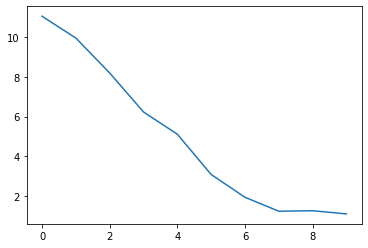

In [7]:
model.run()

In [26]:
model.get_embeddings([0, 1, 2, 3])

array([[[ 0.62823164,  0.6113539 ,  0.27091354, -0.8320651 ,
          0.8537804 ,  1.0629829 ,  0.76362467,  0.41818097,
          0.43743455,  1.349739  ,  0.3319371 , -0.67530227,
         -0.8343452 , -0.63337743, -0.60639054, -0.3814448 ,
          1.2726022 ,  0.9149237 ,  1.7129228 , -0.52208245,
          1.2890255 ,  1.4644632 , -0.35199314,  1.566738  ,
          1.3629692 ,  0.7309564 ,  0.5009302 ,  0.4239938 ,
         -0.22449452, -0.34280473],
        [ 0.7322006 ,  0.3033901 ,  2.0766377 ,  0.10265452,
         -1.0819887 , -0.5036815 , -0.8798283 , -0.9147947 ,
         -2.040438  , -0.09755757,  0.20881218,  1.5499455 ,
         -0.6685353 , -0.18980534, -0.9709377 , -1.0715506 ,
         -0.75623524,  0.41742763, -0.7986104 , -1.6689712 ,
         -0.6250458 , -1.0499108 , -1.6191075 , -0.09947572,
         -0.69404024, -1.4117051 ,  0.5598838 ,  0.63014686,
          0.90360254, -1.0606445 ],
        [ 1.0581857 , -0.19377512, -1.2847675 ,  1.3463356 ,
          0.6